In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [86]:
def visualize_results(file_path='results_metrics.csv'):
    """
    Visualize the results metrics from the CSV file.

    Parameters:
        file_path (str): Path to the results CSV file.
    """
    # Read the CSV file
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist.")
        return
    
    data = pd.read_csv(file_path)

    # Reorder rows alphabetically by dataset_name
    data = data.sort_values(by='dataset_name')

    # Define the metrics to compare
    metrics = ['accuracy', 'f1_score', 'auc', 'precision', 'recall']

    # Create a grouped bar chart for each metric
    for metric in metrics:
        proposed_col = f'proposed_{metric}'
        baseline_col = f'baseline_{metric}'

        # Extract data for the current metric
        datasets = data['dataset_name']
        proposed_values = data[proposed_col].round(2)
        baseline_values = data[baseline_col].round(2)

        # Set up the bar chart
        x = np.arange(len(datasets))  # the label locations
        width = 0.35  # the width of the bars

        # Highlight datasets where proposed outperforms baseline
        colors = ['green' if proposed >= baseline else '#1f77b4' 
                  for proposed, baseline in zip(proposed_values, baseline_values)]

        fig, ax = plt.subplots(figsize=(10, 5))
        bars1 = ax.bar(x - width/2, proposed_values, width, label='Proposed', color=colors)
        bars2 = ax.bar(x + width/2, baseline_values, width, label='Baseline', color='gray')

        # Add labels, title, and legend
        ax.set_xlabel('Dataset')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Comparison of Proposed vs Baseline for {metric.capitalize()}')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        # ax.legend()

        # Add a custom legend for the green color
        custom_legend = [
            plt.Line2D([0], [0], color='green', lw=4, label='JIT-Cat as good or better than Baseline'),
            plt.Line2D([0], [0], color='#1f77b4', lw=4, label='JIT-Cat worse than Baseline'),
            plt.Line2D([0], [0], color='gray', lw=4, label='Baseline')
        ]
        ax.legend(handles=custom_legend, loc='lower left')

        # Add value annotations on top of bars with smaller font size
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=6)
        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=6)

        # Show the plot
        plt.tight_layout()

        plt.savefig(f'comparison_{metric}.pdf', dpi=600, bbox_inches='tight', format="pdf")
        # plt.show()
        plt.close(fig)

In [4]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

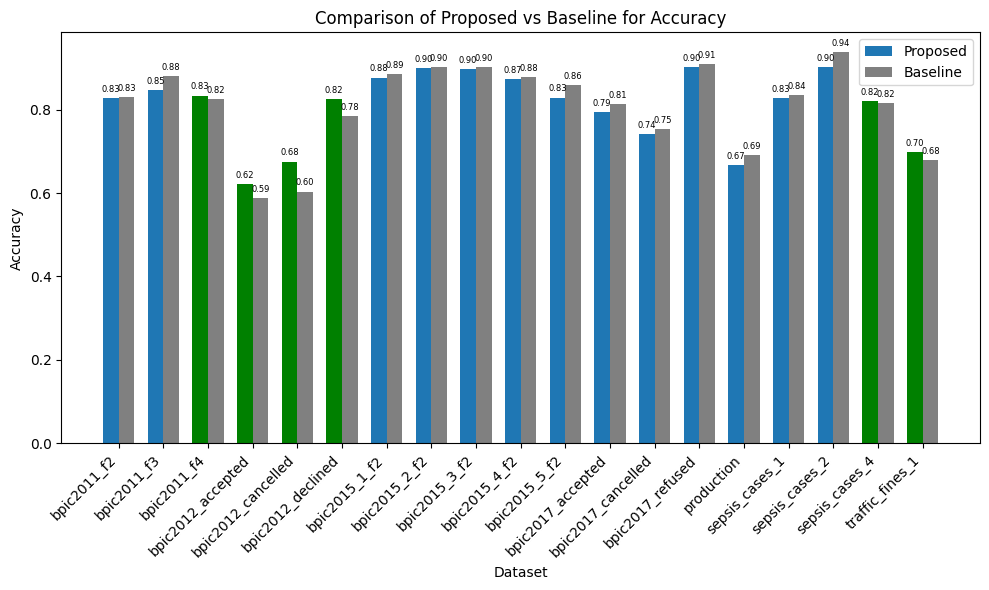

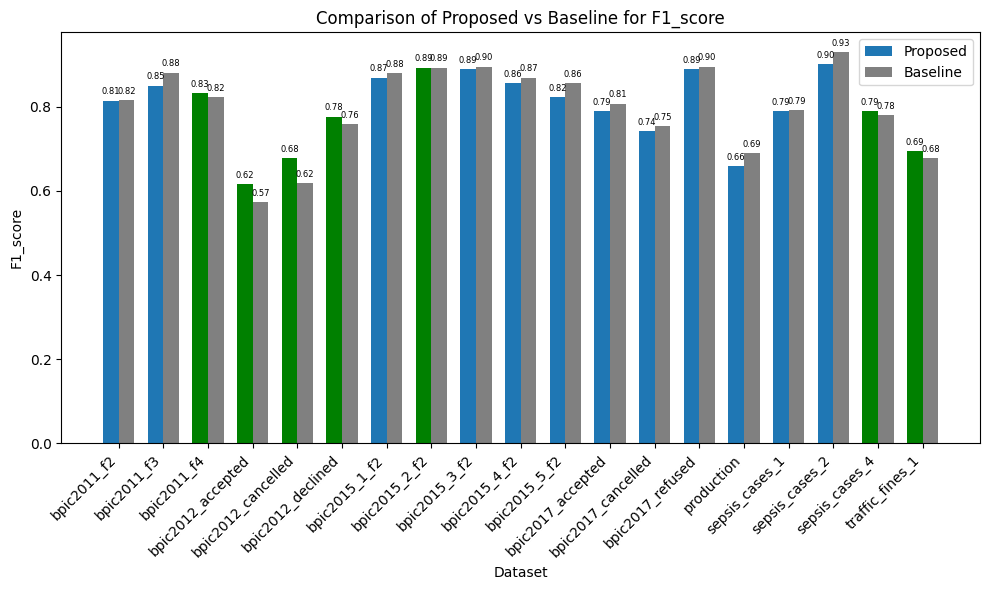

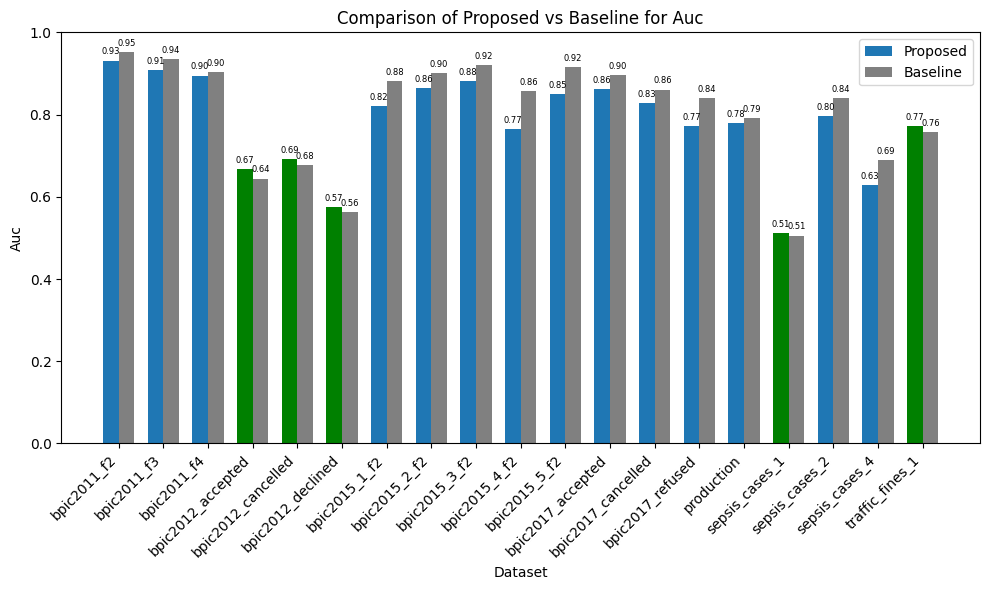

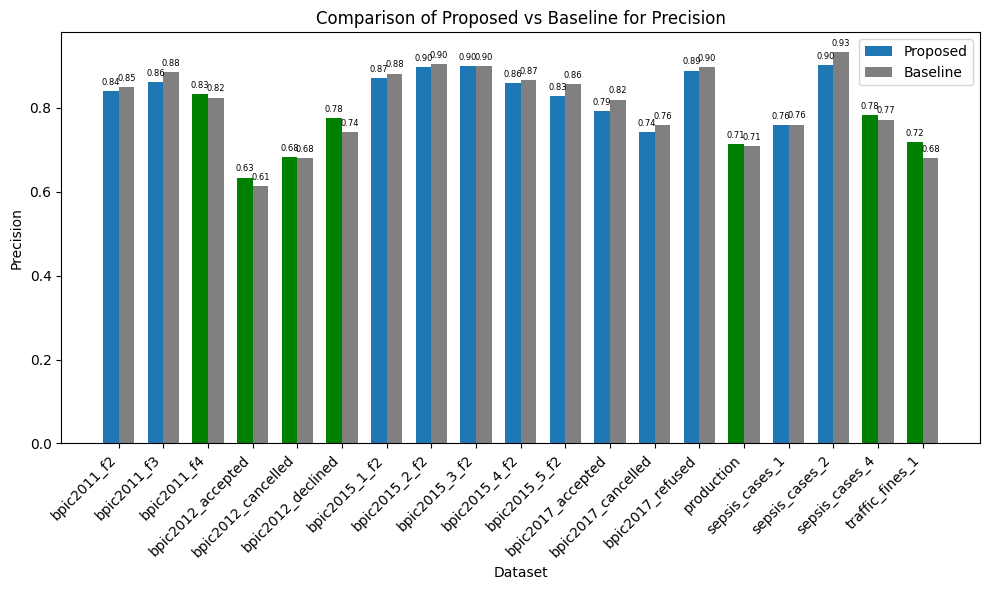

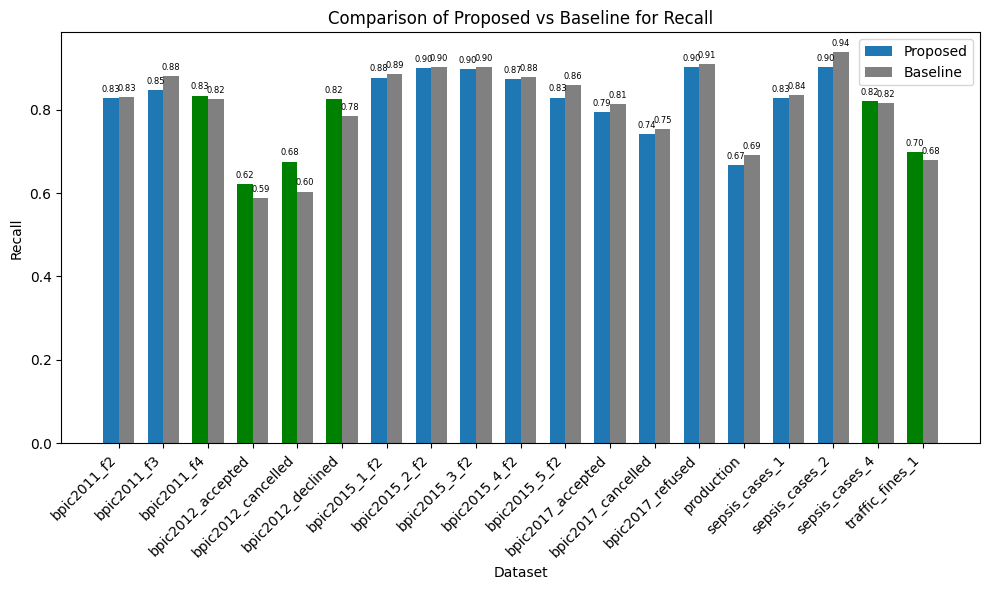

In [27]:
# Call the function to visualize results
visualize_results('results_metrics.csv')

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

def analyze_feature_size_and_metrics(results_file, dataset_file):
    """
    Analyze feature size and metrics based on the results file and dataset.

    Parameters:
        results_file (str): Path to the results_metrics.csv file.
        dataset_file (str): Path to the dataset file.

    Returns:
        None
    """
    # Step 1: Read the results file
    if not os.path.exists(results_file):
        print(f"Results file '{results_file}' not found.")
        return
    results_df = pd.read_csv(results_file)
    print("Results file loaded successfully.")
    print(results_df.head())

    # Step 2: Load the dataset and get its shape
    if not os.path.exists(dataset_file):
        print(f"Dataset file '{dataset_file}' not found.")
        return
    dataset = pd.read_csv(dataset_file)
    print(f"Dataset loaded successfully. Shape: {dataset.shape}")

    # Extract features and target
    target_column = 'target'  # Replace with the actual target column name
    if target_column not in dataset.columns:
        print(f"Target column '{target_column}' not found in the dataset.")
        return
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 3: Analyze metrics with respect to feature size
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    results = {metric: [] for metric in metrics}
    feature_sizes = []

    for k in range(1, X_train.shape[1] + 1):  # Iterate over feature sizes
        # Select top k features
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_k = selector.fit_transform(X_train, y_train)
        X_test_k = selector.transform(X_test)

        # Train a RandomForestClassifier
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_k, y_train)

        # Make predictions
        y_pred = model.predict(X_test_k)

        # Compute metrics
        results['accuracy'].append(accuracy_score(y_test, y_pred))
        results['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))
        results['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        results['recall'].append(recall_score(y_test, y_pred, average='weighted'))

        # Track feature size
        feature_sizes.append(k)

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.plot(feature_sizes, results[metric], label=metric.capitalize())
    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Feature Space Size')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
results_file = 'results_metrics.csv'  # Path to the results file
dataset_file = 'dataset.csv'  # Path to the dataset file
analyze_feature_size_and_metrics(results_file, dataset_file)

Results file loaded successfully.
Data sizes file loaded successfully.


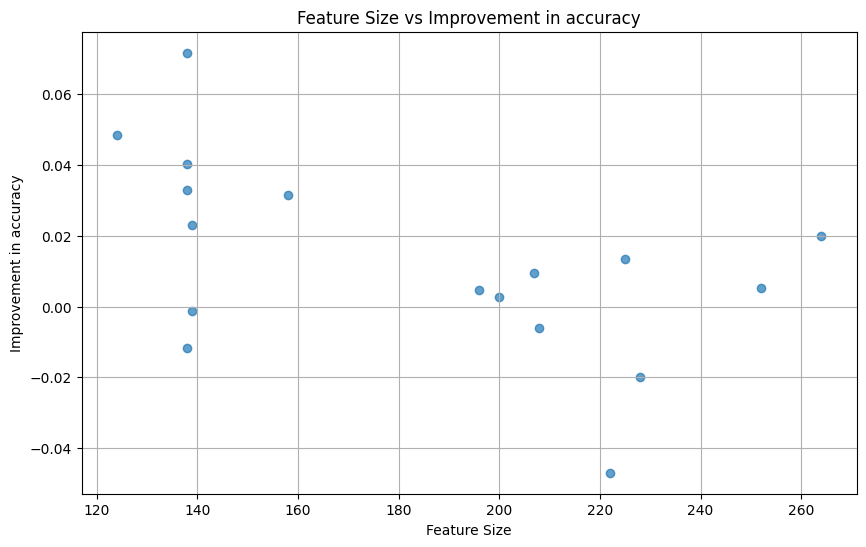

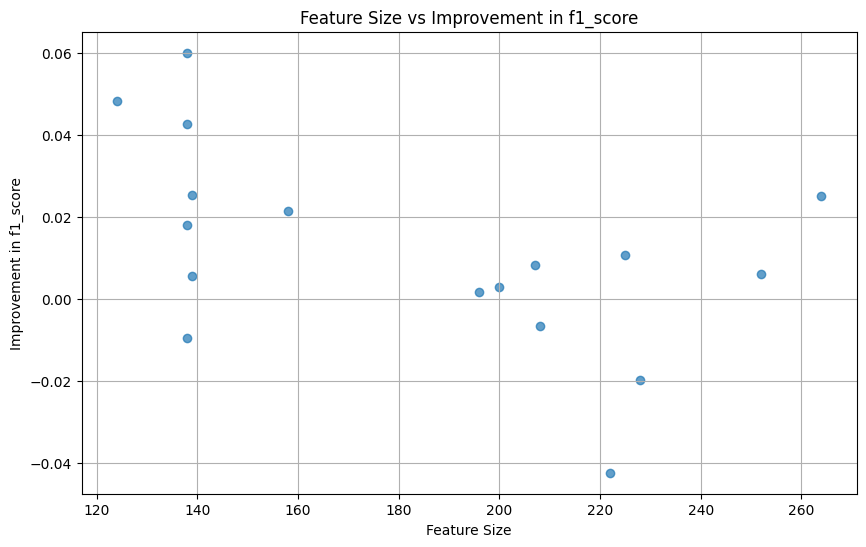

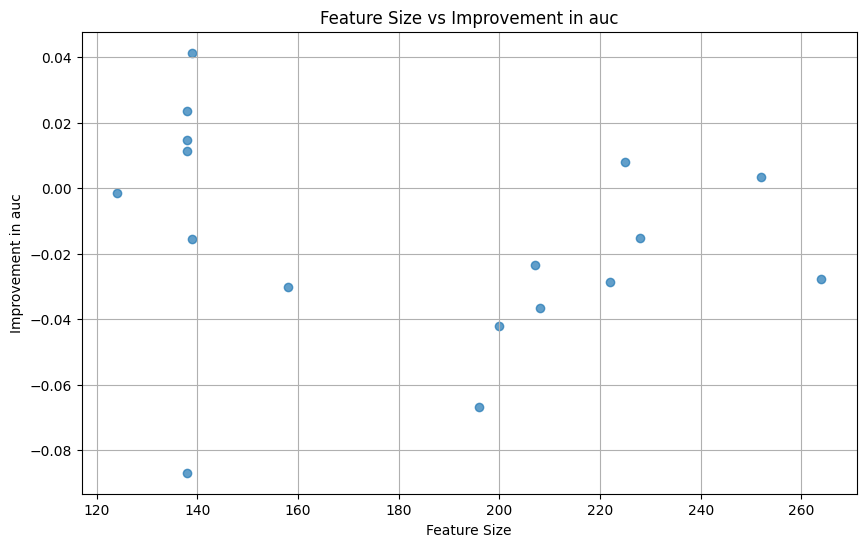

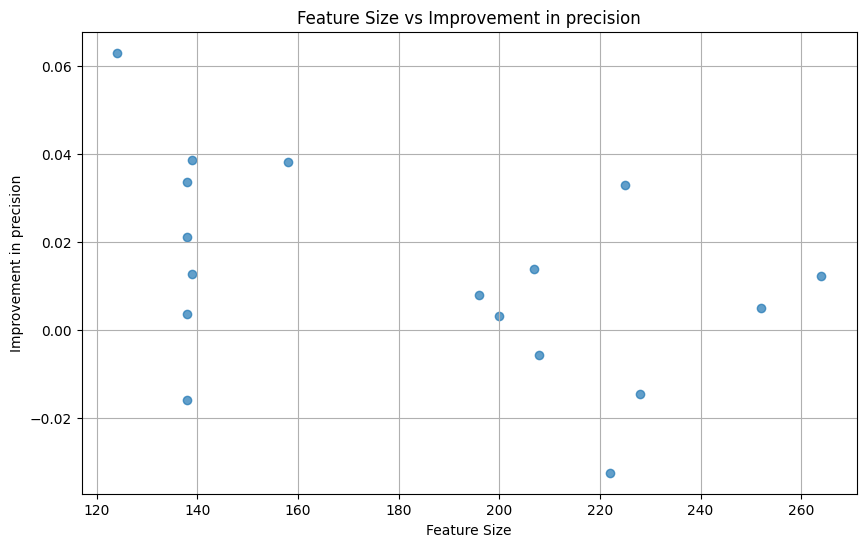

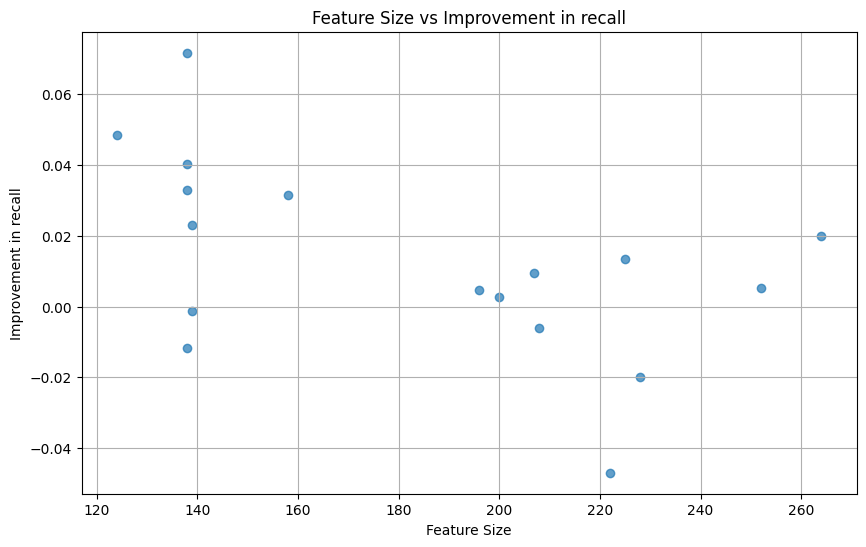

In [39]:
def analyze_correlation_feature_size_and_improvement(results_file, data_sizes_file):
    """
    Analyze correlation between feature size and improvement over baseline metrics for all datasets.

    Parameters:
        results_file (str): Path to the results_metrics.csv file.
        data_sizes_file (str): Path to the data_sizes file containing dataset shapes.

    Returns:
        None
    """
    # Step 1: Read the results file
    if not os.path.exists(results_file):
        print(f"Results file '{results_file}' not found.")
        return
    results_df = pd.read_csv(results_file)
    print("Results file loaded successfully.")

    # Step 2: Load the data_sizes file
    if not os.path.exists(data_sizes_file):
        print(f"Data sizes file '{data_sizes_file}' not found.")
        return
    data_sizes_df = pd.read_csv(data_sizes_file)
    print("Data sizes file loaded successfully.")

    # Step 3: Prepare data for scatter plots
    metrics = ['accuracy', 'f1_score', 'auc', 'precision', 'recall']
    scatter_data = []

    for _, dataset_info in data_sizes_df.iterrows():
        dataset_name = dataset_info['dataset_name']
        feature_size = dataset_info['num_columns'] - 1  # Subtract 1 for the target column

        # Calculate improvement over baseline for each metric
        for metric in metrics:
            proposed_col = f'proposed_{metric}'
            baseline_col = f'baseline_{metric}'
            if proposed_col in results_df.columns and baseline_col in results_df.columns:
                improvement = results_df.loc[results_df['dataset_name'] == dataset_name, proposed_col].values - \
                              results_df.loc[results_df['dataset_name'] == dataset_name, baseline_col].values
                if len(improvement) > 0:
                    scatter_data.append((feature_size, improvement[0], metric, dataset_name))

    # Step 4: Create separate scatter plots for each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        metric_data = [(x, y) for x, y, m, _ in scatter_data if m == metric]
        if metric_data:
            x_values, y_values = zip(*metric_data)
            plt.scatter(x_values, y_values, alpha=0.7)
            plt.xlabel('Feature Size')
            plt.ylabel(f'Improvement in {metric}')
            plt.title(f'Feature Size vs Improvement in {metric}')
            plt.grid()
            plt.show()

# Example usage
results_file = 'results_metrics_HP_tuning_combined.csv'  # Path to the results file
data_sizes_file = 'transformed_dataset_sizes.csv'  # Path to the data_sizes file
analyze_correlation_feature_size_and_improvement(results_file, data_sizes_file)

Results file loaded successfully.
Imbalance file loaded successfully.


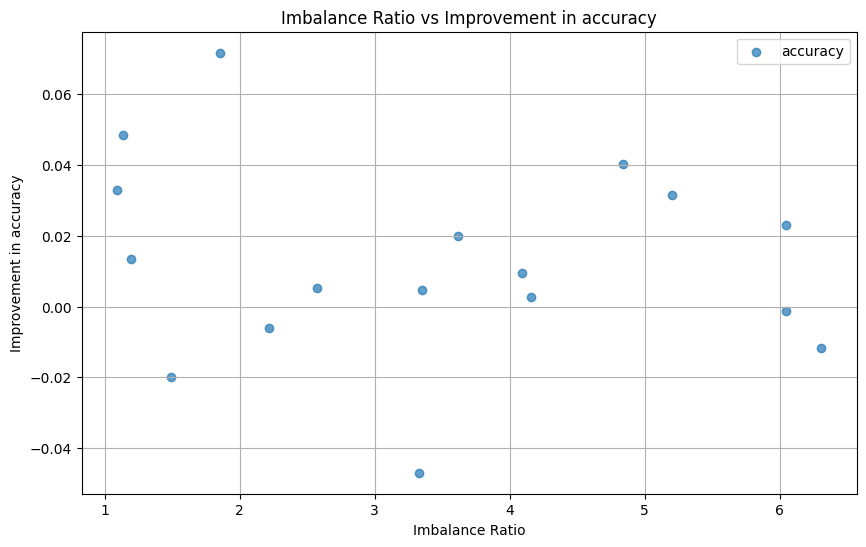

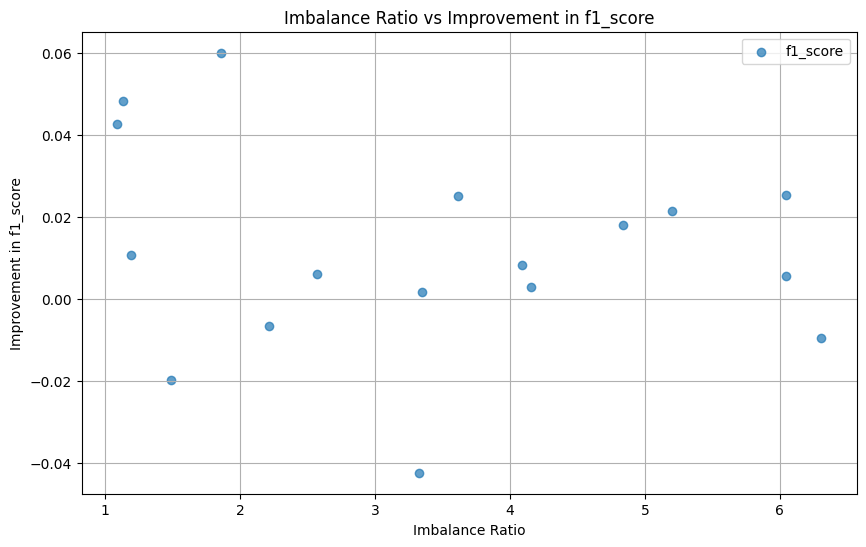

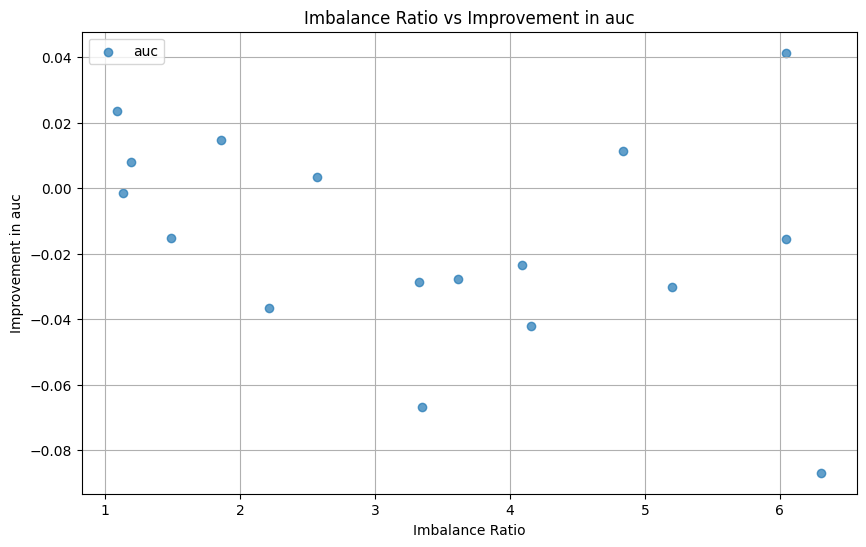

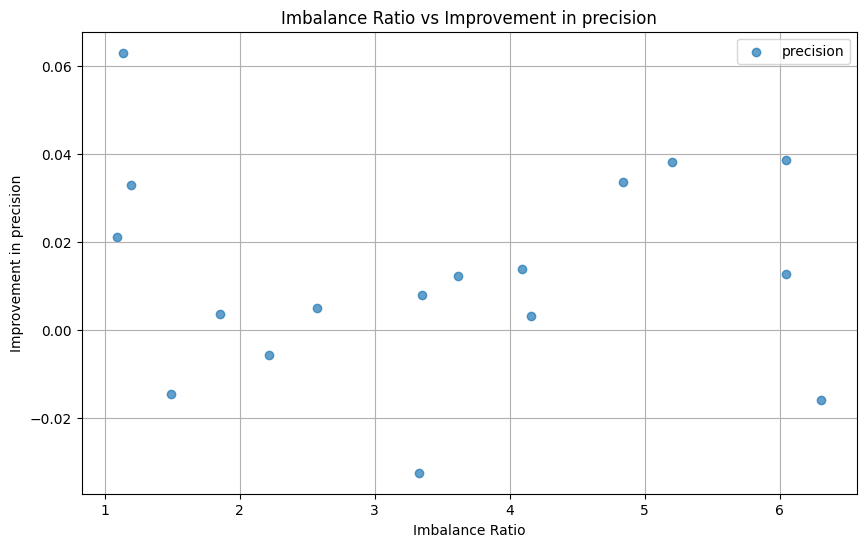

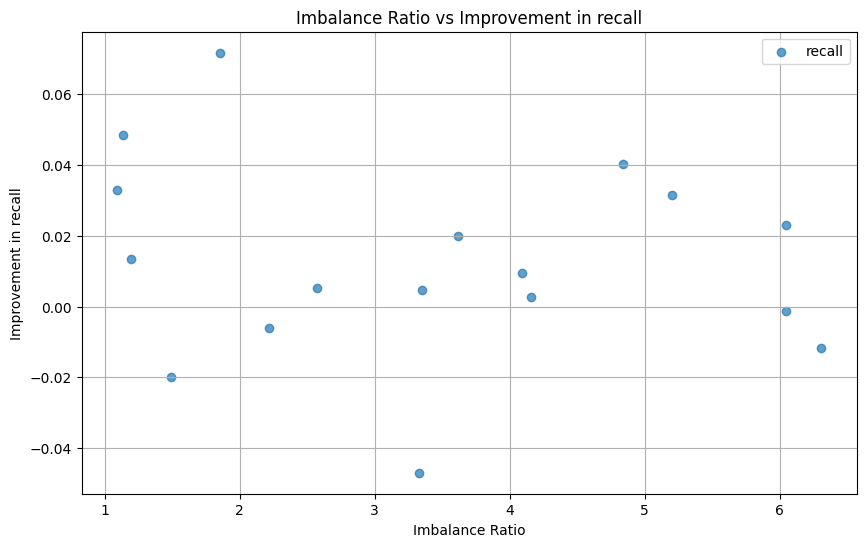

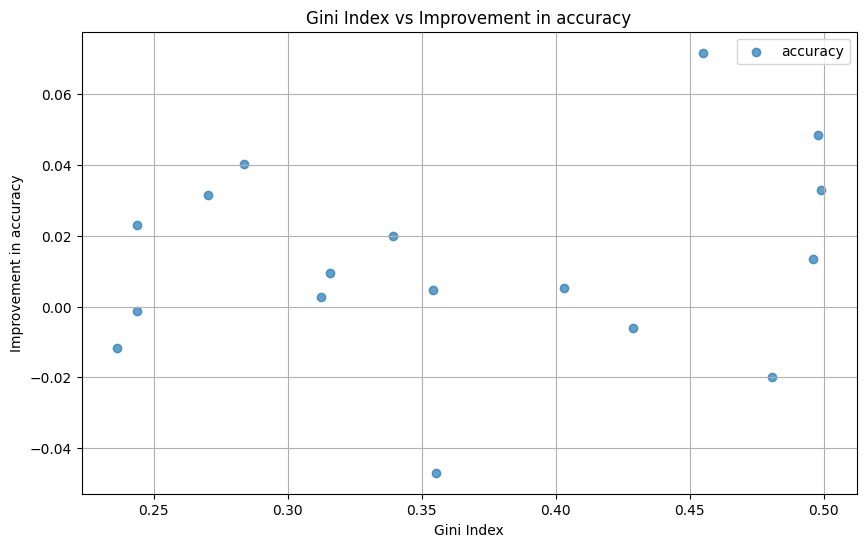

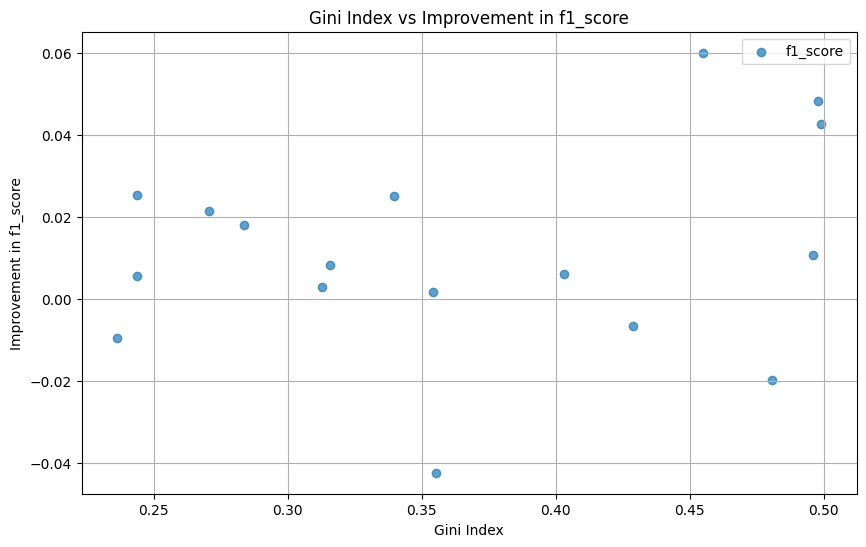

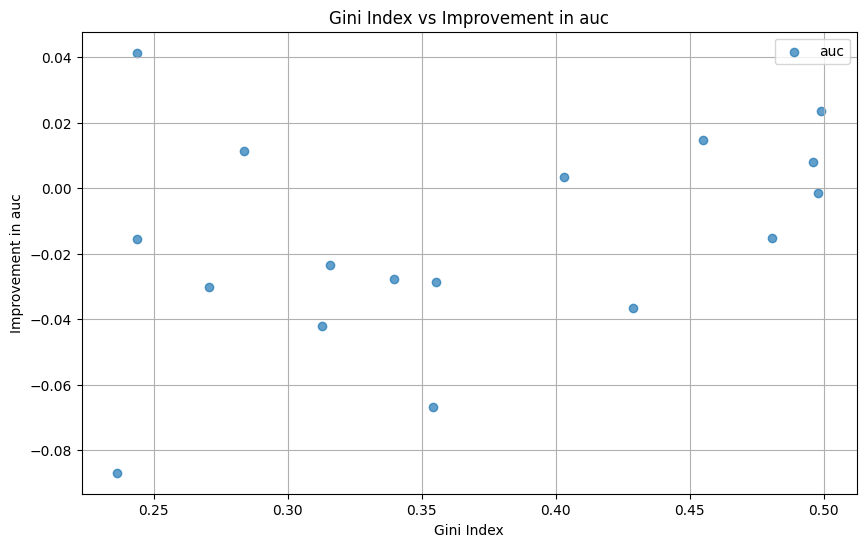

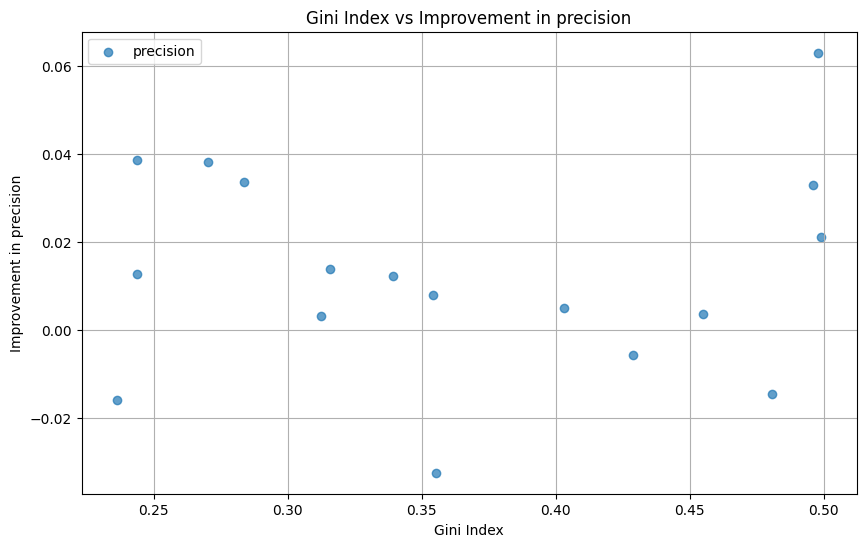

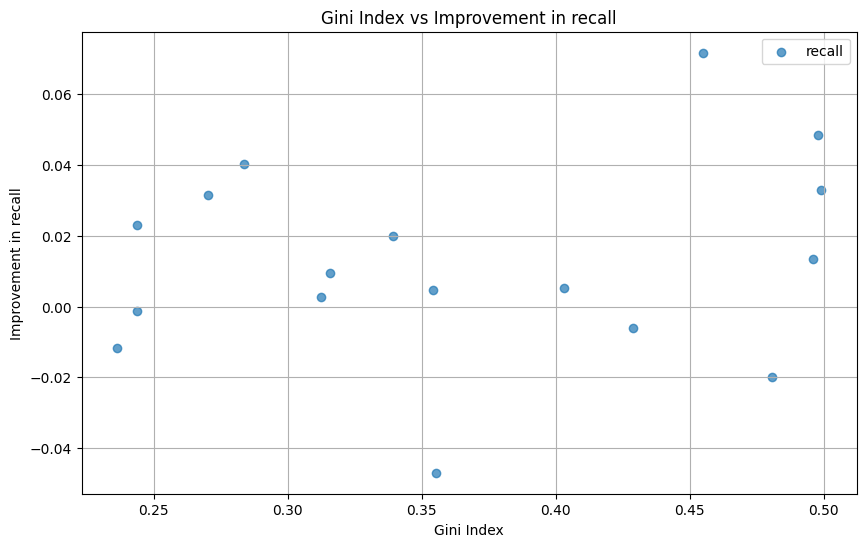

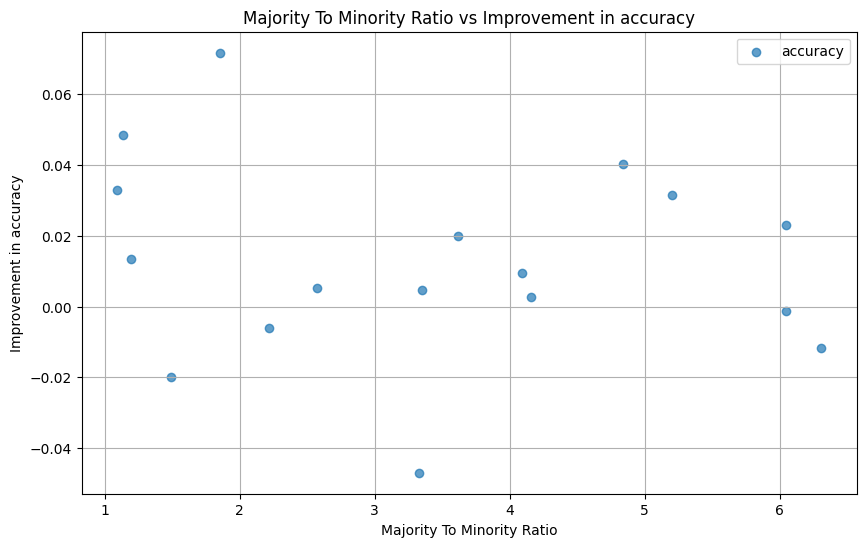

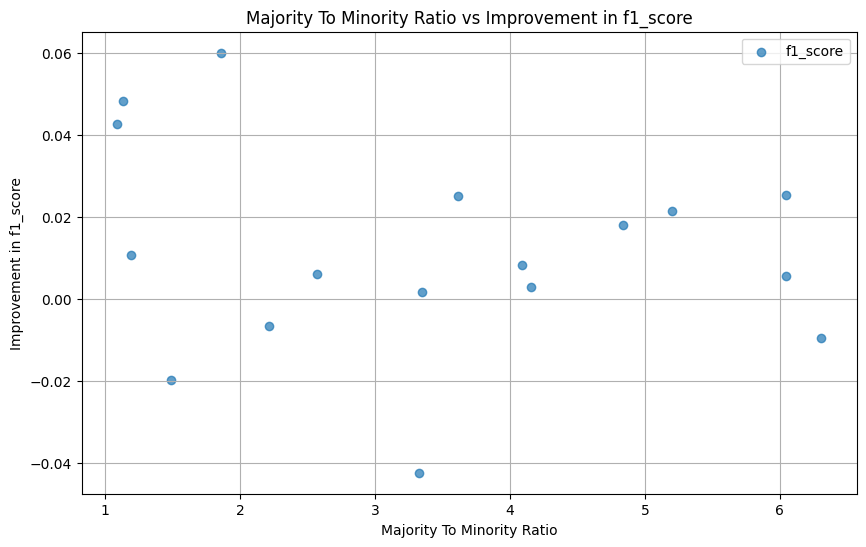

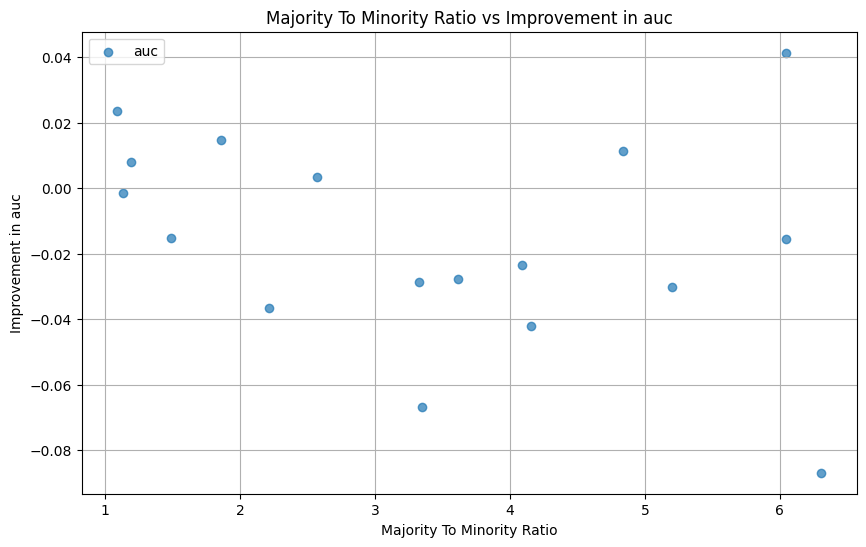

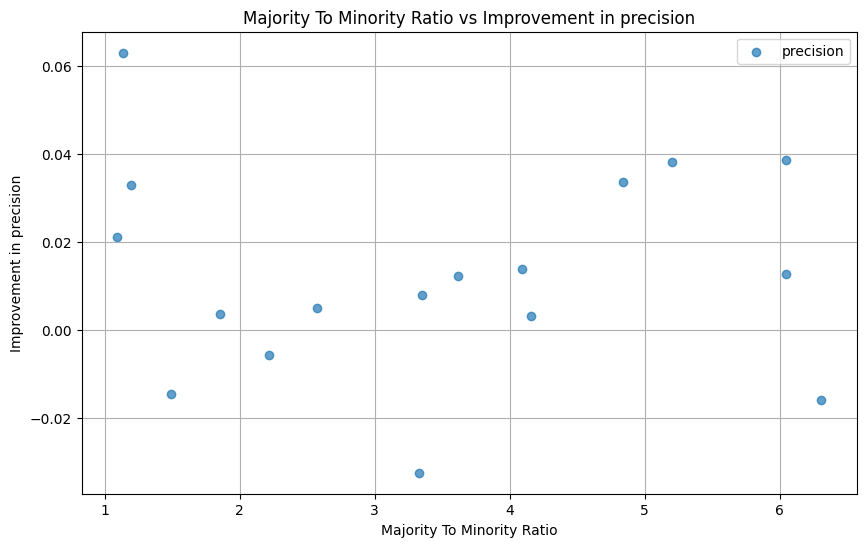

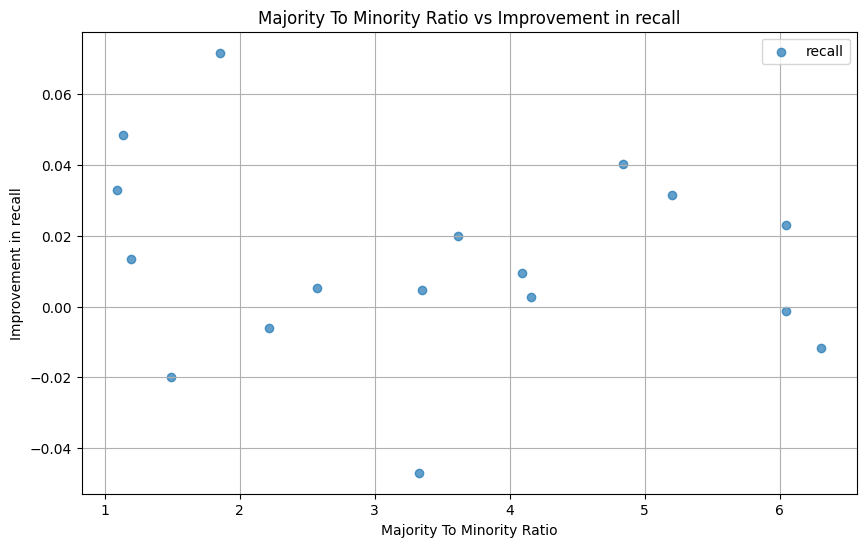

In [38]:
def analyze_correlation_class_imbalance_and_improvement(results_file, imbalance_file):
    """
    Analyze correlation between class imbalance metrics and improvement over baseline metrics for all datasets.

    Parameters:
        results_file (str): Path to the results_metrics.csv file.
        imbalance_file (str): Path to the file containing class imbalance information.

    Returns:
        None
    """
    # Step 1: Read the results file
    if not os.path.exists(results_file):
        print(f"Results file '{results_file}' not found.")
        return
    results_df = pd.read_csv(results_file)
    print("Results file loaded successfully.")

    # Step 2: Load the imbalance file
    if not os.path.exists(imbalance_file):
        print(f"Imbalance file '{imbalance_file}' not found.")
        return
    imbalance_df = pd.read_csv(imbalance_file)
    print("Imbalance file loaded successfully.")

    # Step 3: Prepare data for scatter plots
    metrics = ['accuracy', 'f1_score', 'auc', 'precision', 'recall']
    scatter_data = []

    for _, imbalance_info in imbalance_df.iterrows():
        dataset_name = imbalance_info['dataset_name']
        imbalance_ratio = imbalance_info['imbalance_ratio']
        gini_index = imbalance_info['gini_index']
        majority_to_minority_ratio = imbalance_info['majority_to_minority_ratio']

        # Calculate improvement over baseline for each metric
        for metric in metrics:
            proposed_col = f'proposed_{metric}'
            baseline_col = f'baseline_{metric}'
            if proposed_col in results_df.columns and baseline_col in results_df.columns:
                improvement = results_df.loc[results_df['dataset_name'] == dataset_name, proposed_col].values - \
                              results_df.loc[results_df['dataset_name'] == dataset_name, baseline_col].values
                if len(improvement) > 0:
                    scatter_data.append({
                        "dataset_name": dataset_name,
                        "imbalance_ratio": imbalance_ratio,
                        "gini_index": gini_index,
                        "majority_to_minority_ratio": majority_to_minority_ratio,
                        "improvement": improvement[0],
                        "metric": metric
                    })

    # Step 4: Create scatter plots for each imbalance metric
    imbalance_metrics = ['imbalance_ratio', 'gini_index', 'majority_to_minority_ratio']
    for imbalance_metric in imbalance_metrics:
        for metric in metrics:
            plt.figure(figsize=(10, 6))
            metric_data = [(d[imbalance_metric], d['improvement']) for d in scatter_data if d['metric'] == metric]
            if metric_data:
                x_values, y_values = zip(*metric_data)
                plt.scatter(x_values, y_values, alpha=0.7, label=metric)
                plt.xlabel(imbalance_metric.replace('_', ' ').title())
                plt.ylabel(f'Improvement in {metric}')
                plt.title(f'{imbalance_metric.replace("_", " ").title()} vs Improvement in {metric}')
                plt.grid()
                plt.legend()
                plt.show()

# Example usage
results_file = 'results_metrics_HP_tuning_combined.csv'  # Path to the results file
imbalance_file = 'dataset_imbalance_metrics.csv'  # Path to the imbalance file
analyze_correlation_class_imbalance_and_improvement(results_file, imbalance_file)

In [40]:
df = pd.read_csv('results_metrics_HP_tuning.csv')
df = df[df["dataset_name"].isin(["sepsis_cases_2", "sepsis_cases_4", "bpic2015_1_f2", "bpic2015_2_f2", "production", "bpic2011_f2"])] 

In [41]:
df2 = pd.read_csv('results_metrics_HP_tuning_spartan.csv')
df2 = df2[df2["dataset_name"].isin(["bpic2015_3_f2", "bpic2015_4_f2", "bpic2015_5_f2", "bpic2011_f1", "bpic2011_f3", "bpic2011_f4"])] 

In [42]:
df3 = pd.read_csv('results_metrics.csv')
df3 = df3[df3["dataset_name"].isin(["bpic2012_accepted", "bpic2012_cancelled", "bpic2012_declined", "traffic_fines_1"])]
df3

,dataset_name,proposed_accuracy,proposed_f1_score,proposed_auc,proposed_precision,proposed_recall,baseline_accuracy,baseline_f1_score,baseline_auc,baseline_precision,baseline_recall
0,bpic2012_accepted,0.621027,0.616624,0.667827,0.633787,0.621027,0.587994,0.574000,0.644336,0.612700,0.587994
4,bpic2012_cancelled,0.675255,0.679021,0.691669,0.683821,0.675255,0.603579,0.619011,0.676959,0.680308,0.603579
5,bpic2012_declined,0.824449,0.777025,0.574089,0.776116,0.824449,0.784124,0.758979,0.562651,0.742450,0.784124
6,traffic_fines_1,0.697269,0.693957,0.772365,0.719110,0.697269,0.678275,0.678581,0.757816,0.680701,0.678275


In [43]:
df4 = pd.read_csv('results_metrics_dimension_reduction.csv')
df4 = df4[df4["dataset_name"].isin(["sepsis_cases_1"])]
df4

,dataset_name,proposed_accuracy,proposed_f1_score,proposed_auc,proposed_precision,proposed_recall,baseline_accuracy,baseline_f1_score,baseline_auc,baseline_precision,baseline_recall
1,sepsis_cases_1,0.83347,0.797776,0.520045,0.773971,0.83347,0.834619,0.792167,0.478753,0.761204,0.834619


In [44]:
# Concatenate df and df2
concatenated_df = pd.concat([df, df2, df3, df4], ignore_index=True)
concatenated_df


,dataset_name,proposed_accuracy,proposed_f1_score,proposed_auc,proposed_precision,proposed_recall,baseline_accuracy,baseline_f1_score,baseline_auc,baseline_precision,baseline_recall
0,bpic2015_1_f2,0.889599,0.881781,0.831718,0.889157,0.889599,0.885058,0.880184,0.898352,0.881181,0.885058
1,bpic2015_2_f2,0.908239,0.900944,0.864688,0.907901,0.908239,0.905490,0.897927,0.906656,0.904651,0.905490
2,sepsis_cases_2,0.926999,0.920856,0.772368,0.919457,0.926999,0.938767,0.930337,0.859195,0.935477,0.938767
3,sepsis_cases_4,0.831585,0.798279,0.661135,0.799090,0.831585,0.808611,0.772916,0.676803,0.760534,0.808611
4,production,0.717926,0.709638,0.777550,0.779035,0.717926,0.669596,0.661414,0.778982,0.715955,0.669596
5,bpic2011_f2,0.845115,0.838212,0.921810,0.849341,0.845115,0.825330,0.813120,0.949480,0.837109,0.825330
6,bpic2015_4_f2,0.895231,0.878631,0.782570,0.891509,0.895231,0.863761,0.857115,0.812613,0.853241,0.863761
7,bpic2011_f3,0.847570,0.851798,0.913223,0.861372,0.847570,0.894516,0.894177,0.942010,0.893895,0.894516
8,bpic2011_f1,0.812707,0.813150,0.908067,0.822905,0.812707,0.832478,0.832956,0.923189,0.837519,0.832478
9,bpic2015_5_f2,0.844905,0.841576,0.882921,0.843930,0.844905,0.850876,0.848213,0.919619,0.849711,0.850876


In [36]:
concatenated_df.sort_values(by='dataset_name', inplace=True)
concatenated_df.to_csv('results_metrics_HP_tuning_combined.csv', index=False)


In [87]:
# Call the function to visualize results
visualize_results('results_metrics_HP_tuning_combined.csv')

In [104]:
def calculate_moving_avg_f1(df, true_col, pred_col, dataset_manager, window_size=5):
    # Sort the DataFrame by the timestamp column
    df = df.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort')

    # Convert columns to numpy arrays for faster operations
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    # Preallocate arrays for results
    num_rows = np.arange(2, len(true_values) + 1)  # Start from 2
    f1_list = np.zeros(len(num_rows))

    # Compute F1 scores incrementally
    for i in range(2, len(true_values) + 1):
        f1_list[i - 2] = f1_score(true_values[:i], predicted_values[:i], average='weighted')

    # Create a DataFrame for results
    f1_df = pd.DataFrame({'num_rows': num_rows, 'f1': f1_list})

    # Compute the moving average of F1 scores
    f1_df['moving_avg_f1'] = f1_df['f1'].rolling(window=window_size, min_periods=1).mean()

    return f1_df

In [111]:
from data.DatasetManager import DatasetManager
from sklearn.metrics import f1_score

In [127]:
dataset_name = 'traffic_fines_1'  
dataset_manager = DatasetManager(dataset_name)

In [128]:
df_production = pd.read_csv(f'./results_HP_tuning/{dataset_name}/grid_search_results.csv')
best_result = df_production.loc[df_production['f1_score'].idxmax()]

FileNotFoundError: [Errno 2] No such file or directory: './results_HP_tuning/traffic_fines_1/grid_search_results.csv'

In [129]:
tmp = pd.read_csv(f'./results/{dataset_name}/baseline_catboost.csv')
tmp.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)

/var/folders/sb/50cj9frx6576wh5j6rbpnb6c0000gp/T/ipykernel_10541/546542706.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(f'./results/{dataset_name}/baseline_catboost.csv')


In [130]:
tmp2 = pd.read_csv(f'./results/{dataset_name}/Catboost_300_euclidean.csv')
tmp2.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)

/var/folders/sb/50cj9frx6576wh5j6rbpnb6c0000gp/T/ipykernel_10541/4031379475.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp2 = pd.read_csv(f'./results/{dataset_name}/Catboost_300_euclidean.csv')


In [131]:
# Calculate moving average accuracy for tmp and tmp2
mae_df_tmp = calculate_moving_avg_f1(tmp, dataset_manager.label_col, 'predicted_value', dataset_manager)
mae_df_tmp2 = calculate_moving_avg_f1(tmp2, dataset_manager.label_col, 'predicted_value', dataset_manager)

KeyboardInterrupt: 

In [123]:
# Plot the moving average F1 score for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_f1'], label='baseline', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_f1'], label='JIT-Cat', color='red')
# plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='euclidean', color='green')
# plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='DTW', color='black')
plt.xlabel('Number of Observed Events over Time')
plt.ylabel('Moving Average F1 Score')
plt.title(f'{dataset_name} Moving Average F1 Score')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(f"results/{dataset_name}/moving_avg_f1_score.png", dpi=600, bbox_inches='tight')
plt.savefig(f"results/{dataset_name}/moving_avg_F1_score.pdf", dpi=600, bbox_inches='tight', format="pdf")  # Save as PDF
plt.close()